# Importing the libraries

In [9]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import tensorflow as tf
import shap

In [10]:
data = pd.read_csv("YS01 - Test Data.csv") #loading a dataset
print(data.shape) #number of rows and columns 

(103, 13)


In [11]:
data.describe() #general statistics

,Index,Hole Scavenger (mM),Catalyst amount (umol),QD amount (umol),H2 Area,CH4 Area,CO Area,pH before,pH after,Time
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,24.000000,30.000000,103.000000
mean,52.000000,135.378641,0.189267,0.000863,234.602445,61.885107,12156.875203,6.090833,5.979667,22.533728
std,29.877528,133.968691,0.510282,0.000391,224.914241,83.247479,16441.798879,0.491227,0.404675,7.077719
min,1.000000,0.000000,0.000000,0.000000,0.246000,0.000000,0.762800,4.670000,4.670000,4.000000
25%,26.500000,100.000000,0.000400,0.000800,64.093100,18.740100,2411.734300,6.012500,5.927500,23.000000
50%,52.000000,100.000000,0.002000,0.000800,185.733600,36.828500,6873.664600,6.275000,6.120000,24.000000
75%,77.500000,100.000000,0.010000,0.000800,288.234500,63.701800,12489.721250,6.370000,6.222500,27.000000
max,103.000000,900.000000,2.000000,0.002000,1000.759800,550.416800,72757.168000,6.540000,6.350000,29.000000


In [12]:
data.head() #first 5

,Index,QDs,Hole Scavengar,Catalyst,Hole Scavenger (mM),Catalyst amount (umol),QD amount (umol),H2 Area,CH4 Area,CO Area,pH before,pH after,Time
0,1,ZnSe,NaAsc,FeCl3,100,0.0002,0.0008,44.6310,21.4564,1814.1244,NaN,5.95,24.0
1,2,ZnSe,NaAsc,FeCl3,100,0.0020,0.0008,109.6600,23.6980,5444.0798,NaN,6.03,24.0
2,3,ZnSe,NaAsc,FeCl3,100,0.0100,0.0008,124.1470,27.3552,11515.6370,NaN,6.08,24.0
3,4,ZnSe,NaAsc,FeCl3,100,0.2000,0.0008,232.4260,73.7740,72757.1680,NaN,5.75,24.0
4,5,ZnSe,NaAsc,FeCl3,100,1.0000,0.0008,493.4962,190.1524,39207.7339,NaN,4.75,24.0


In [13]:
data.dtypes #types of features

Index                       int64
QDs                        object
Hole Scavengar             object
Catalyst                   object
Hole Scavenger (mM)         int64
Catalyst amount (umol)    float64
QD amount (umol)          float64
H2 Area                   float64
CH4 Area                  float64
CO Area                   float64
pH before                 float64
pH after                  float64
Time                      float64
dtype: object

# Preprocessing

In [15]:
catalyst_encoder = LabelEncoder() #to convert the name of the catalyst to some index (without it error!)

data.drop(['Index'],axis=1,inplace=True) #dropping the column index
data.drop(['QDs'],axis=1,inplace=True) #dropping the column "QDs"
data.drop(['Hole Scavengar'],axis=1,inplace=True) #dropping the column "Hole Scavenger"

data['Catalyst'] = catalyst_encoder.fit_transform(data['Catalyst']) #transforming objects in indexes
label_mapping = dict(zip(catalyst_encoder.classes_, catalyst_encoder.transform(catalyst_encoder.classes_)))
print(label_mapping) #printing out the dictionary 

#data.drop(['Time '],axis=1,inplace=True)

data = data.fillna(0) #filling out the N/A with 0s 

features_scaler = StandardScaler() #scaler for features
target_scaler = StandardScaler() #scaler for target

data_pipeline = Pipeline([
        ('std_scaler', features_scaler), #creating a pipeline with it 
    ])

target_pipeline = Pipeline([
        ('std_scaler', target_scaler), #creating a pipeline with it 
    ])

target = data['CO Area'] #selecting the target 
features = data.drop('CO Area', axis=1) #features are all the columns except the target

columns_f = features.columns #getting the names of the features
features = data_pipeline.fit_transform(features) #scaling the features 
features = pd.DataFrame(features,columns=columns_f) #transforming back into dataframe

target = data_pipeline.fit_transform(target.to_numpy().reshape(-1,1)) 
target = pd.DataFrame(target,columns=['CO Area'])


{'Co-TPP-COOH4': 0, 'CoCl2': 1, 'FeCl2': 2, 'FeCl3': 3, 'MnCl2': 4, 'ZnAc2': 5, 'ZnCl2': 6, nan: 7}


In [16]:
#split
x_train, X_test, y_train, Y_test = train_test_split(features, target, test_size=0.3, random_state=21) #best performing random states 21, 41
index_before = Y_test.index #indices before sorting
Y_test = Y_test.sort_values(by='CO Area') #sorting the test values by CO Area column 
sorted_indices = Y_test.index #indices after sorting 

In [17]:
data.corr()['CO Area'].sort_values(ascending=False) #correlation table (approximate correlation between variables)

CO Area                   1.000000
H2 Area                   0.636416
Catalyst amount (umol)    0.574936
CH4 Area                  0.449164
pH after                  0.338916
pH before                 0.204087
Time                      0.147696
Catalyst                  0.030353
QD amount (umol)         -0.064496
Hole Scavenger (mM)      -0.093661
Name: CO Area, dtype: float64

In [18]:
data.corr()['H2 Area'].sort_values(ascending=False) #correlation table (approximate correlation between variables)

H2 Area                   1.000000
CH4 Area                  0.733479
Catalyst amount (umol)    0.690888
CO Area                   0.636416
Time                      0.211103
pH after                  0.172585
pH before                 0.134280
Hole Scavenger (mM)       0.116036
Catalyst                 -0.001315
QD amount (umol)         -0.132267
Name: H2 Area, dtype: float64

In [19]:
def rmse(y_actual, y_predicted):
    """
    Calculate the Root Mean Squared Error (RMSE) between actual and predicted values.
    
    Args:
    y_actual (array-like): Actual values.
    y_predicted (array-like): Predicted values.
    
    Returns:
    float: The RMSE value.
    """
    from sklearn.metrics import mean_squared_error  # Import mean_squared_error from sklearn
    from math import sqrt  # Import sqrt from math module to calculate the square root
    return sqrt(mean_squared_error(y_actual, y_predicted))  # Calculate and return the RMSE

def plotShap(shap_values):
    """
    Plot the SHAP (SHapley Additive exPlanations) values to show feature importances.
    
    Args:
    shap_values (numpy.ndarray): SHAP values for features.
    """
    # Calculate the mean absolute SHAP values for each feature
    mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

    # Sort feature names and SHAP values together
    sorted_indices = np.argsort(mean_abs_shap_values)  # Get indices of sorted SHAP values
    sorted_feature_names = columns_f[sorted_indices]  # Sort feature names according to SHAP values
    sorted_mean_abs_shap_values = mean_abs_shap_values[sorted_indices]  # Sort SHAP values

    # Calculate evaluation metrics
    mse = mean_squared_error(Y_test, pred)  # Calculate Mean Squared Error (MSE)
    rmse = np.sqrt(mse)  # Calculate Root Mean Squared Error (RMSE)
    r2 = r2_score(Y_test, pred)  # Calculate R^2 score

    # Plot a vertical bar chart of feature importances with values
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.figtext(0.87, 0.12, f"MSE: {mse:.5f}, RMSE: {rmse:.5f}, R2: {r2:.5f}", horizontalalignment='right')  # Add text for metrics
    plt.barh(range(len(sorted_feature_names)), sorted_mean_abs_shap_values, color='blue')  # Plot horizontal bar chart
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)  # Set y-ticks with feature names
    plt.xlabel('Mean Absolute SHAP Value')  # Set x-axis label
    plt.title('Feature Importances with SHAP Values')  # Set plot title

    # Add values next to the bars
    for index, value in enumerate(sorted_mean_abs_shap_values):
        plt.text(value, index, f'{value:.2f}', va='center')  # Add text values next to bars

    plt.show()  # Display the plot
    return

def sortChart(Y_test):
    """
    Sort the true values and predicted values based on the 'CO Area' column in Y_test.
    
    Args:
    Y_test (pandas.DataFrame): The true values with 'CO Area' column.
    """
    index_before = Y_test.index.copy()  # Copy the original indices
    Y_test = Y_test.sort_values(by='CO Area')  # Sort Y_test by 'CO Area'
    sorted_indices = Y_test.index  # Get the sorted indices

    # Sort y_test and pred using the sorted indices
    for i in range(len(index_before)):
        for j in range(len(sorted_indices)):
            if index_before[i] == sorted_indices[j]:  # Match original indices with sorted indices
                pred[i], pred[j] = pred[j], pred[i]  # Swap predicted values accordingly
    return

def display_results():
    """
    Display the results by creating a dataframe with X_test, y_test, and predictions.
    """
    # Create a dataframe with X_test, y_test, and predictions
    results_df = pd.DataFrame(X_test)  # Convert X_test to a DataFrame
    results_df['True Values'] = Y_test  # Add true values to the DataFrame
    results_df['Predicted Values'] = pred  # Add predicted values to the DataFrame

    # Display the dataframe
    print(results_df)  # Print the DataFrame


In [20]:
def rmse(y_actual, y_predicted):
    """
    Calculate the Root Mean Squared Error (RMSE) between actual and predicted values.
    
    Args:
    y_actual (array-like): Actual values.
    y_predicted (array-like): Predicted values.
    
    Returns:
    float: The RMSE value.
    """
    from sklearn.metrics import mean_squared_error  # Import mean_squared_error from sklearn
    from math import sqrt  # Import sqrt from math module to calculate the square root
    return sqrt(mean_squared_error(y_actual, y_predicted))  # Calculate and return the RMSE

def plotShap(shap_values):
    """
    Plot the SHAP (SHapley Additive exPlanations) values to show feature importances.
    
    Args:
    shap_values (numpy.ndarray): SHAP values for features.
    """
    # Calculate the mean absolute SHAP values for each feature
    mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

    # Sort feature names and SHAP values together
    sorted_indices = np.argsort(mean_abs_shap_values)  # Get indices of sorted SHAP values
    sorted_feature_names = columns_f[sorted_indices]  # Sort feature names according to SHAP values
    sorted_mean_abs_shap_values = mean_abs_shap_values[sorted_indices]  # Sort SHAP values

    # Calculate evaluation metrics
    mse = mean_squared_error(Y_test, pred)  # Calculate Mean Squared Error (MSE)
    rmse = np.sqrt(mse)  # Calculate Root Mean Squared Error (RMSE)
    r2 = r2_score(Y_test, pred)  # Calculate R^2 score

    # Plot a vertical bar chart of feature importances with values
    plt.figure(figsize=(10, 6))  # Set figure size
    plt.figtext(0.87, 0.12, f"MSE: {mse:.5f}, RMSE: {rmse:.5f}, R2: {r2:.5f}", horizontalalignment='right')  # Add text for metrics
    plt.barh(range(len(sorted_feature_names)), sorted_mean_abs_shap_values, color='blue')  # Plot horizontal bar chart
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)  # Set y-ticks with feature names
    plt.xlabel('Mean Absolute SHAP Value')  # Set x-axis label
    plt.title('Feature Importances with SHAP Values')  # Set plot title

    # Add values next to the bars
    for index, value in enumerate(sorted_mean_abs_shap_values):
        plt.text(value, index, f'{value:.2f}', va='center')  # Add text values next to bars

    plt.show()  # Display the plot
    return

def sortChart(Y_test):
    """
    Sort the true values and predicted values based on the 'CO Area' column in Y_test.
    
    Args:
    Y_test (pandas.DataFrame): The true values with 'CO Area' column.
    """
    index_before = Y_test.index.copy()  # Copy the original indices
    Y_test = Y_test.sort_values(by='CO Area')  # Sort Y_test by 'CO Area'
    sorted_indices = Y_test.index  # Get the sorted indices

    # Sort y_test and pred using the sorted indices
    for i in range(len(index_before)):
        for j in range(len(sorted_indices)):
            if index_before[i] == sorted_indices[j]:  # Match original indices with sorted indices
                pred[i], pred[j] = pred[j], pred[i]  # Swap predicted values accordingly
    return

def display_results():
    """
    Display the results by creating a dataframe with X_test, y_test, and predictions.
    """
    # Create a dataframe with X_test, y_test, and predictions
    results_df = pd.DataFrame(X_test)  # Convert X_test to a DataFrame
    results_df['True Values'] = Y_test  # Add true values to the DataFrame
    results_df['Predicted Values'] = pred  # Add predicted values to the DataFrame

    # Display the dataframe
    print(results_df)  # Print the DataFrame


In [21]:
def best_hiper_search(features_train, target_train):
    """
    Perform hyperparameter search for Decision Tree Regressor, Random Forest Regressor, and XGBoost Regressor.
    
    Args:
    features_train (array-like): Training features.
    target_train (array-like): Training target values.
    """
    # Define hyperparameter grids for the models
    parametrs_DTR = {'max_depth': range(1, 13, 1)}
    parametrs_RFR = {'n_estimators': range(1, 10, 2), 'max_depth': range(1, 10, 1)}
    parametrs_XGB = {'max_depth': range(1, 10, 1), 'n_estimators': range(1, 10, 2)}
    
    # Create a custom RMSE scorer
    rmse_scorer = make_scorer(rmse, greater_is_better=True)
    
    # Initialize GridSearchCV for each model
    grid_DTR = GridSearchCV(DecisionTreeRegressor(), parametrs_DTR, cv=5, scoring=rmse_scorer)
    grid_RFR = GridSearchCV(RandomForestRegressor(), parametrs_RFR, cv=5, scoring=rmse_scorer)
    grid_XGB = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), parametrs_XGB, cv=5, scoring=rmse_scorer)
    
    # Fit the GridSearchCV for each model
    grid_DTR.fit(features_train, target_train)
    grid_RFR.fit(features_train, target_train)
    grid_XGB.fit(features_train, target_train)
    
    # Print the best scores and parameters for each model
    print("DecisionTreeRegressor", grid_DTR.scorer_, grid_DTR.best_score_, grid_DTR.best_params_)
    print("RandomForestRegressor", grid_RFR.scorer_, grid_RFR.best_score_, grid_RFR.best_params_)
    print("XGBRegressor", grid_XGB.scorer_, grid_XGB.best_score_, grid_XGB.best_params_)
    return

# Function to split, train, and evaluate the XGBoost model
def evaluate_random_state_xgb(random_state):
    """
    Split the dataset, train an XGBoost model, and evaluate its performance.
    
    Args:
    random_state (int): Random state for train_test_split and model training.
    
    Returns:
    tuple: MSE, RMSE, and R2 score of the model.
    """
    # Split the dataset using train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=random_state)
    
    # Train an XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return mse, rmse, r2

# Function to split, train, and evaluate the Decision Tree Regressor model
def evaluate_random_state_dtr(random_state):
    """
    Split the dataset, train a Decision Tree Regressor model, and evaluate its performance.
    
    Args:
    random_state (int): Random state for train_test_split and model training.
    
    Returns:
    tuple: MSE, RMSE, and R2 score of the model.
    """
    # Split the dataset using train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=random_state)
    
    # Train a Decision Tree Regressor model
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return mse, rmse, r2

# Function to split, train, and evaluate the Random Forest Regressor model
def evaluate_random_state_rfr(random_state):
    """
    Split the dataset, train a Random Forest Regressor model, and evaluate its performance.
    
    Args:
    random_state (int): Random state for train_test_split and model training.
    
    Returns:
    tuple: MSE, RMSE, and R2 score of the model.
    """
    # Split the dataset using train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.3, random_state=random_state)
    
    # Train a Random Forest Regressor model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return mse, rmse, r2

# Print statement indicating the selection of hyperparameters
print("Selection of hyperparameters:")
# best_hiper_search(x_train, y_train)  # Uncomment to run hyperparameter search
print('')


Selection of hyperparameters:



# Linear Regression 

In [23]:
model = LinearRegression(fit_intercept = True) #building linear regression model 

In [24]:
def display_scores(scores):
    """
    Display the RMSE scores, their mean, and standard deviation.
    
    Args:
    scores (array-like): Array of RMSE scores.
    """
    print("Scores:", scores)  # Print the RMSE scores
    print("Mean:", scores.mean())  # Print the mean of the scores
    print("Standard deviation:", scores.std())  # Print the standard deviation of the scores

from sklearn.model_selection import cross_val_score

# Calculate cross-validated negative mean squared error scores
scores = cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
# Convert negative MSE scores to positive RMSE scores
rmse_scores = np.sqrt(-scores)
# Display the RMSE scores
display_scores(rmse_scores)


Scores: [1.23982109 0.30571491 1.58666362 0.71175476 0.35596939 0.73779249
 0.78755484 1.14189714 0.91783381 0.45657891]
Mean: 0.824158095857697
Standard deviation: 0.3883883906161131


In [25]:
# Fit the model on the training data
model.fit(x_train, y_train)

# Make predictions on the test data
pred = model.predict(X_test)

# Calculate and print the Root Mean Squared Error (RMSE)
rmse = mean_squared_error(Y_test, pred)**0.5
print('RMSE: ', rmse)

# Calculate and print the Mean Absolute Error (MAE)
mae = mean_absolute_error(Y_test, pred)
print('Mean Absolute Error of the model is: ', mae)

# Calculate and print the accuracy (score) of the model on the test data
accuracy = model.score(X_test, Y_test)
print("Accuracy:", -accuracy)  # Note: The negative sign here might be incorrect depending on context

# Calculate and print the R^2 score
r2 = r2_score(Y_test, pred)
print("R2: ", -r2)  # Note: The negative sign here might be incorrect depending on context

RMSE:  0.7212881245989073
Mean Absolute Error of the model is:  0.5370062518205908
Accuracy: 0.14467824019386466
R2:  0.14467824019386466


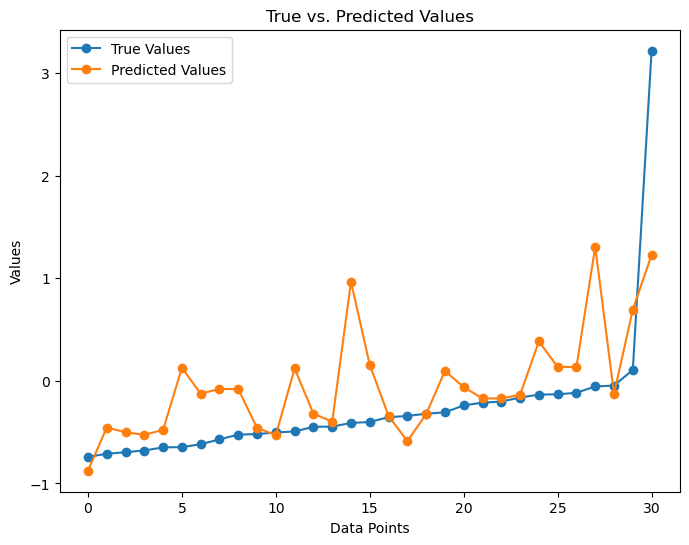

In [26]:
#Sorting
dictionary = {index: prediction for index, prediction in zip(index_before, pred)}
pred = np.array([dictionary[idx] for idx in sorted_indices])

# arr = []
# # Sort y_test and pred using the sorted indices
# for i in range(0,len(index_before)):
#     for j in range(0,len(sorted_indices)):
#         if index_before[i] == sorted_indices[j]:
#             #pred[i], pred[j] = pred[j], pred[i]
#             arr.append(j)
# pred = pred[arr]
#print(pred)
plt.figure(figsize=(8, 6))

plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# Plot predicted values
plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')

# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs. Predicted Values')
plt.legend()
plt.show()

#display_results()

# Decision Tree Regressor 

RMSE:  0.16298987265402248
Mean Absolute Error of the model is:  0.11969119514714611
R2:  -0.9415496516070923
Scores: [0.75755874 0.16106612 1.8532582  0.18496206 0.73284655 0.23633443
 0.55901151 1.4246574  0.60944979 0.50739765]
Mean: 0.7026542449943991
Standard deviation: 0.5191653486982757
Аccuracy : 0.9280579359614154


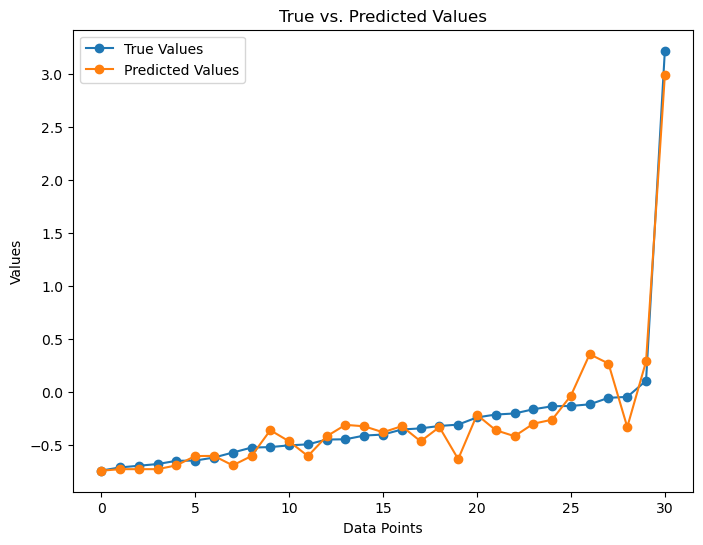

In [28]:
model = DecisionTreeRegressor()
model.fit(x_train, y_train)
pred = model.predict(X_test)

#Sorting
dictionary = {index: prediction for index, prediction in zip(index_before, pred)}
pred = np.array([dictionary[idx] for idx in sorted_indices])

print('RMSE: ', mean_squared_error(Y_test, pred)**0.5)
#Calculation of Mean Absolute Error
mae = mean_absolute_error(Y_test, pred)
print('Mean Absolute Error of the model is: ', mae)
accuracy = model.score(X_test, Y_test)
r2 = r2_score(Y_test, pred)
print("R2: ", -r2)
scores = cross_val_score(model, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)
print("Аccuracy", ":", -accuracy)

plt.figure(figsize=(8, 6))

# Plot true values
plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# Plot predicted values
plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')


# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

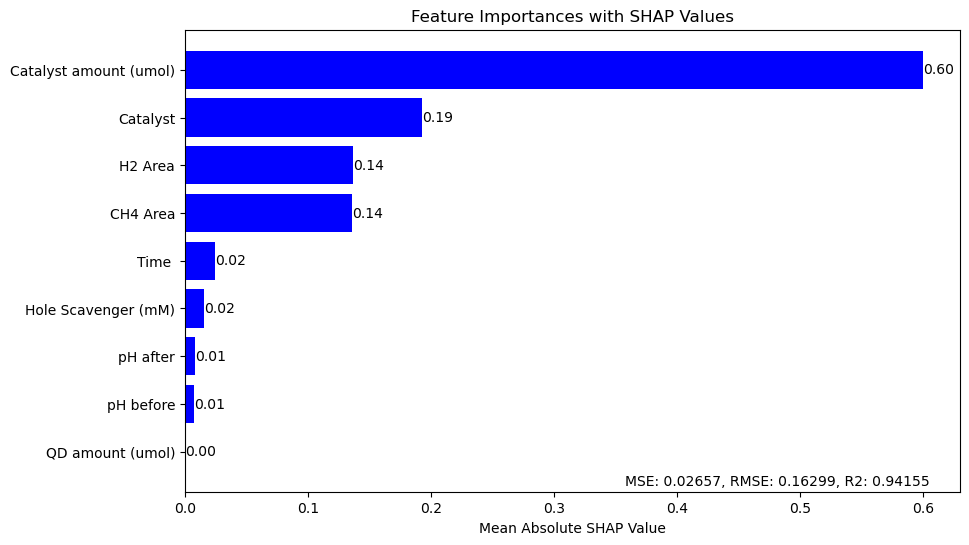

In [29]:
# Create a SHAP explainer object
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Compute the base value (expected value of the model output)
base_value = explainer.expected_value
#shap.summary_plot(shap_values, X_test, feature_names=columns_f)
plotShap(shap_values)

Best Random State:
Random State    21.000000
MSE              0.029635
RMSE             0.172148
R²               0.934797
Name: 21, dtype: float64


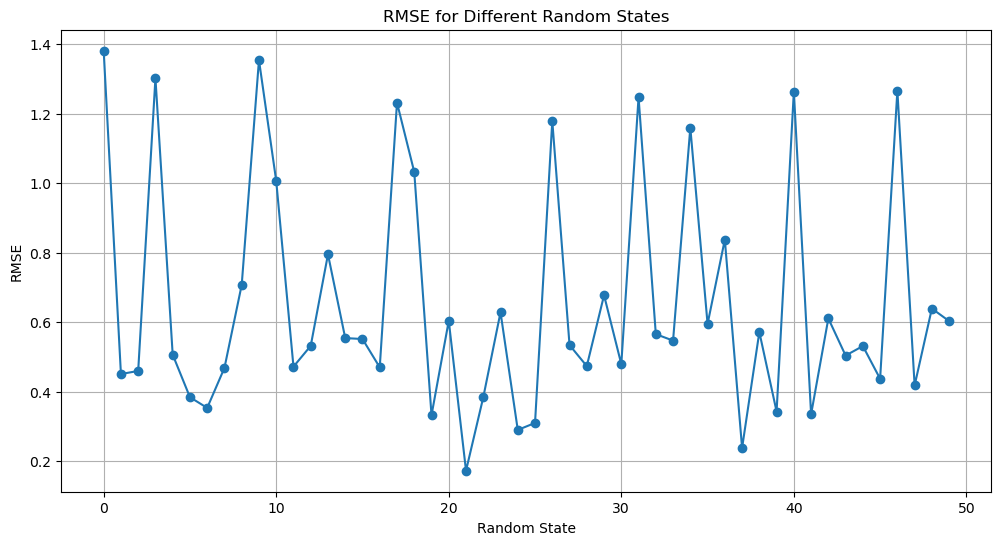

In [30]:
# Try different random states and record performance
results = []
for random_state in range(50):  # Try 50 different random states
    mse, rmse, r2 = evaluate_random_state_dtr(random_state)
    results.append((random_state, mse, rmse, r2))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Random State', 'MSE', 'RMSE', 'R²'])

# Find the best random state based on RMSE
best_random_state = results_df.loc[results_df['RMSE'].idxmin()]

print("Best Random State:")
print(best_random_state)

# Optionally, plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results_df['Random State'], results_df['RMSE'], marker='o')
plt.title('RMSE for Different Random States')
plt.xlabel('Random State')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


# Random Forest Regressor

RMSE:  0.21552794757758895
Mean Absolute Error of the model is:  0.13314421361934037
Аccuracy : -0.738117445589846
R2:  0.8977947865059845


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was

Scores: [0.8686988  0.16317311 0.62326012 0.63001835 0.21372461 0.24485883
 0.47430727 1.22770926 0.52431171 0.26366406]
Mean: 0.5233726110183113
Standard deviation: 0.31776460508522686


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


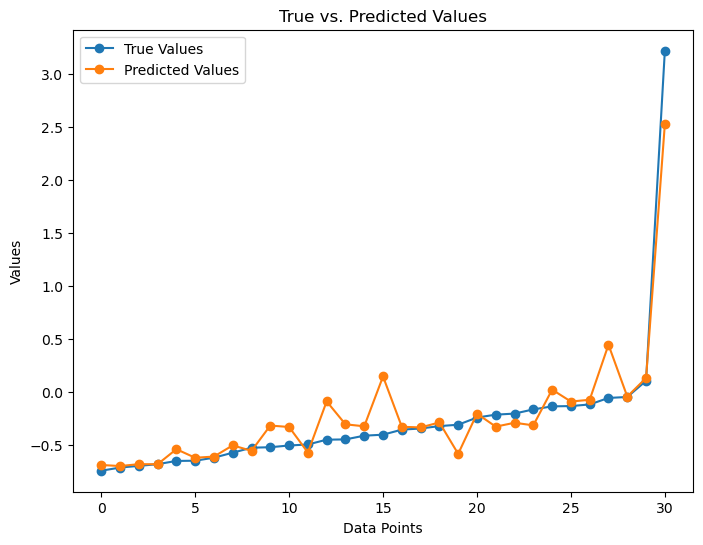

In [32]:
model = RandomForestRegressor(max_depth = 6)
model.fit(x_train, y_train)
pred = model.predict(X_test)

#Sorting
dictionary = {index: prediction for index, prediction in zip(index_before, pred)}
pred = np.array([dictionary[idx] for idx in sorted_indices])

print('RMSE: ', mean_squared_error(Y_test, pred)**0.5)
#Calculation of Mean Absolute Error
mae = mean_absolute_error(Y_test, pred)
print('Mean Absolute Error of the model is: ', mae)
accuracy = model.score(X_test, Y_test)
print("Аccuracy", ":", accuracy)
r2 = r2_score(Y_test, pred)
print("R2: ", r2)
scores = cross_val_score(model, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)
plt.figure(figsize=(8, 6))

# Plot true values
plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# Plot predicted values
plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')


# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

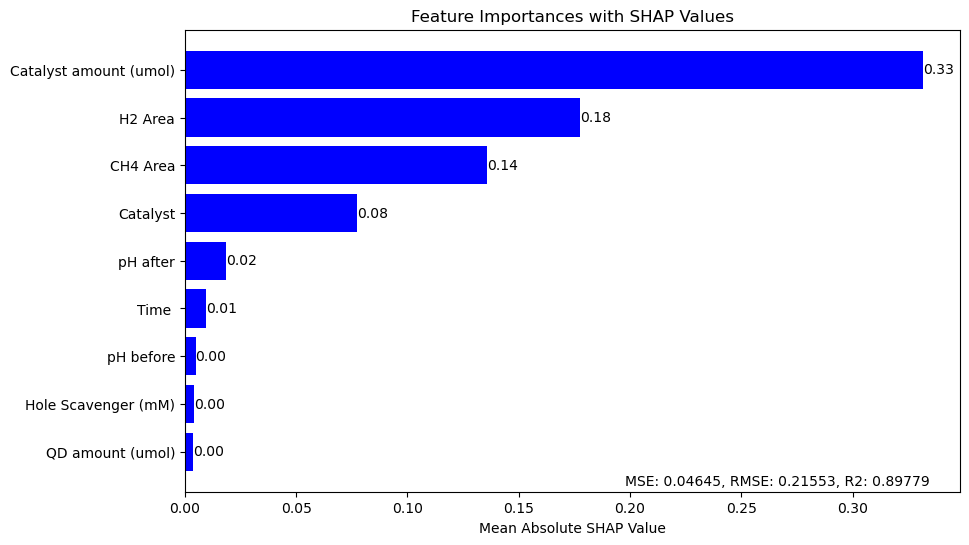

In [33]:
# Create a SHAP explainer object
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Compute the base value (expected value of the model output)
base_value = explainer.expected_value
#shap.summary_plot(shap_values, X_test, feature_names=columns_f)
plotShap(shap_values)

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was

Best Random State:
Random State    21.000000
MSE              0.059100
RMSE             0.243104
R²               0.869968
Name: 21, dtype: float64


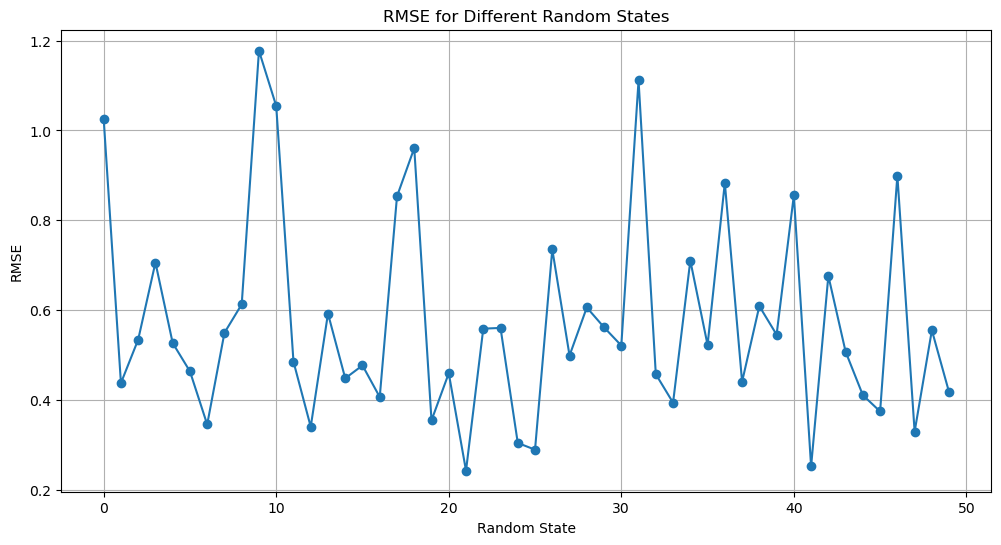

In [34]:
# Try different random states and record performance
results = []
for random_state in range(50):  # Try 50 different random states
    mse, rmse, r2 = evaluate_random_state_rfr(random_state)
    results.append((random_state, mse, rmse, r2))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Random State', 'MSE', 'RMSE', 'R²'])

# Find the best random state based on RMSE
best_random_state = results_df.loc[results_df['RMSE'].idxmin()]

print("Best Random State:")
print(best_random_state)

# Optionally, plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results_df['Random State'], results_df['RMSE'], marker='o')
plt.title('RMSE for Different Random States')
plt.xlabel('Random State')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


# SVR

RMSE:  0.44520733350341385
Mean Absolute Error of the model is:  0.23796471533670818
Аccuracy : -0.4117032916901633
R2:  -0.563895586195686
Scores: [0.85638253 0.1879426  1.27100885 0.90957902 0.42895509 0.32348081
 0.87974577 1.08300973 0.75522369 1.68857325]
Mean: 0.8383901342643787
Standard deviation: 0.4289147024470214


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d arr

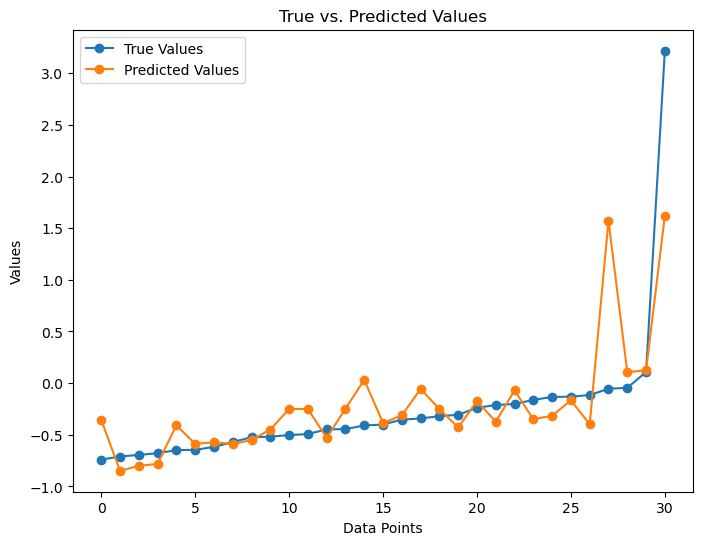

In [36]:
model = SVR(kernel='rbf', C=100, gamma=0.1)
model.fit(x_train, y_train)
pred = model.predict(X_test)

#Sorting
dictionary = {index: prediction for index, prediction in zip(index_before, pred)}
pred = np.array([dictionary[idx] for idx in sorted_indices])

print('RMSE: ', mean_squared_error(Y_test, pred)**0.5)
#Calculation of Mean Absolute Error
mae = mean_absolute_error(Y_test, pred)
print('Mean Absolute Error of the model is: ', mae)
accuracy = model.score(X_test, Y_test)
print("Аccuracy", ":", accuracy)
r2 = r2_score(Y_test, pred)
print("R2: ", -r2)
scores = cross_val_score(model, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)
plt.figure(figsize=(8, 6))

# Plot true values
plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# Plot predicted values
plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')


# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

# Lasso Model

In [38]:
# lasso_reg = Lasso(alpha=0.1)
# lasso_reg.fit(x_train, y_train)
# pred = model.predict(X_test)
# print('RMSE: ', mean_squared_error(Y_test, pred)**0.5)
# #Calculation of Mean Absolute Error
# mae = mean_absolute_error(Y_test, pred)
# print('Mean Absolute Error of the model is: ', mae)
# accuracy = model.score(X_test, Y_test)
# print("Аccuracy", ":", accuracy)

# scores = cross_val_score(model, x_train, y_train,
#                                 scoring="neg_mean_squared_error", cv=10)
# rmse_scores = np.sqrt(-scores)
# display_scores(rmse_scores)
# plt.figure(figsize=(8, 6))

# # Plot true values
# plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# # Plot predicted values
# plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')


# # Add labels and legend
# plt.xlabel('Data Points')
# plt.ylabel('Values')
# plt.title('True vs. Predicted Values')
# plt.legend()

# plt.show()

# Elastic Net

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d arr

RMSE:  0.44520733350341385
Mean Absolute Error of the model is:  0.23796471533670818
Аccuracy : -0.4117032916901633
R2:  -0.563895586195686
Scores: [0.85638253 0.1879426  1.27100885 0.90957902 0.42895509 0.32348081
 0.87974577 1.08300973 0.75522369 1.68857325]
Mean: 0.8383901342643787
Standard deviation: 0.4289147024470214


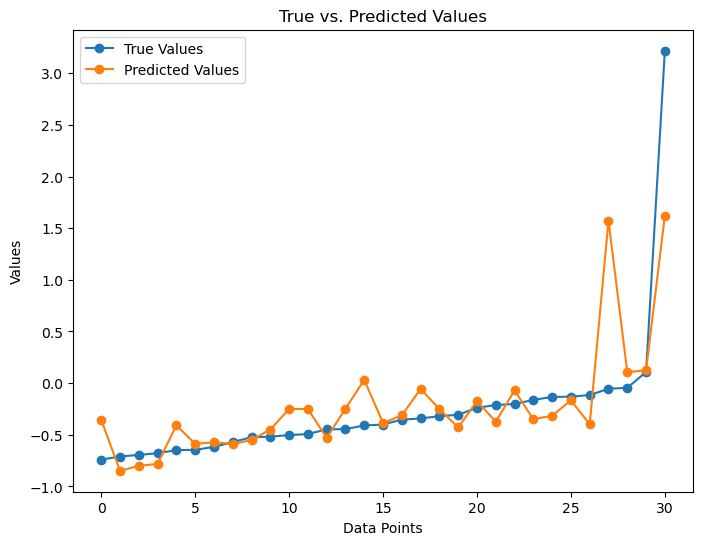

In [40]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(x_train, y_train)
pred = model.predict(X_test)

#Sorting
dictionary = {index: prediction for index, prediction in zip(index_before, pred)}
pred = np.array([dictionary[idx] for idx in sorted_indices])

print('RMSE: ', mean_squared_error(Y_test, pred)**0.5)
#Calculation of Mean Absolute Error
mae = mean_absolute_error(Y_test, pred)
print('Mean Absolute Error of the model is: ', mae)
accuracy = model.score(X_test, Y_test)
print("Аccuracy", ":", accuracy)
r2 = r2_score(Y_test, pred)
print("R2: ", -r2)
scores = cross_val_score(model, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)
plt.figure(figsize=(8, 6))

# Plot true values
plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# Plot predicted values
plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')


# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

# Ensemble 

RMSE:  0.17032965584958631
Mean Absolute Error of the model is:  0.12980255922421863
Аccuracy : -0.4117032916901633
R2:  0.9361668316504701
Scores: [0.85638253 0.1879426  1.27100885 0.90957902 0.42895509 0.32348081
 0.87974577 1.08300973 0.75522369 1.68857325]
Mean: 0.8383901342643787
Standard deviation: 0.4289147024470214


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d arra

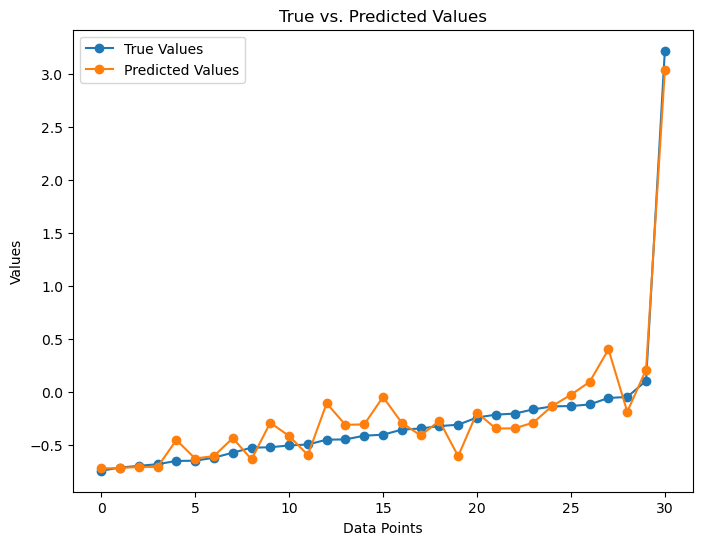

In [42]:
dtr = DecisionTreeRegressor(random_state=42)
rfr = RandomForestRegressor(random_state=42)
voter = VotingRegressor(
    estimators=[('dtr', dtr), ('rfr', rfr)])
voter.fit(x_train, y_train)
pred = voter.predict(X_test)

#Sorting
dictionary = {index: prediction for index, prediction in zip(index_before, pred)}
pred = np.array([dictionary[idx] for idx in sorted_indices])

print('RMSE: ', mean_squared_error(Y_test, pred)**0.5)
#Calculation of Mean Absolute Error
mae = mean_absolute_error(Y_test, pred)
print('Mean Absolute Error of the model is: ', mae)
accuracy = model.score(X_test, Y_test)
print("Аccuracy", ":", accuracy)
r2 = r2_score(Y_test, pred)
print("R2: ", r2)
scores = cross_val_score(model, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)
plt.figure(figsize=(8, 6))

# Plot true values
plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# Plot predicted values
plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')


# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

# XGB Regressor 

RMSE:  0.14676040903719736
Mean Absolute Error of the model is:  0.11231590877316441
Аccuracy : -0.8958942303548676
R2:  0.9526103293683855
Scores: [0.61633295 0.11419091 0.7774724  0.71216812 0.36030444 0.33212818
 0.4672287  1.43523379 0.63155001 0.55543249]
Mean: 0.6002041994381018
Standard deviation: 0.3358257897049371


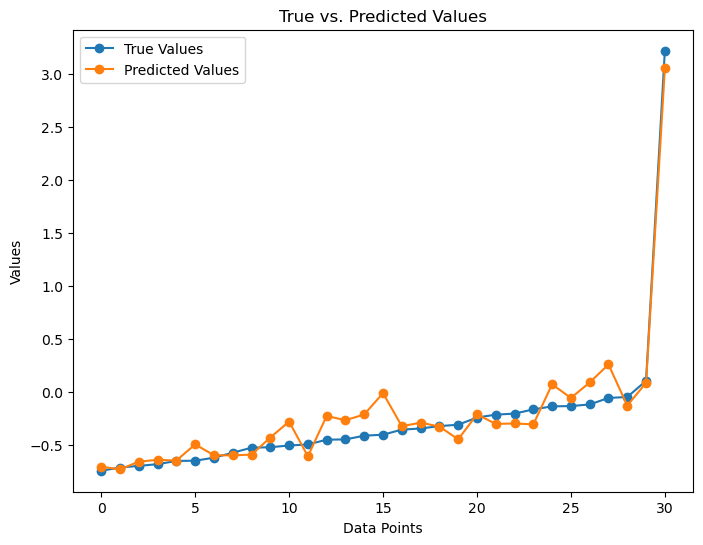

In [44]:
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(x_train, y_train)
pred = model.predict(X_test)

#Sorting
dictionary = {index: prediction for index, prediction in zip(index_before, pred)}
pred = np.array([dictionary[idx] for idx in sorted_indices])

print('RMSE: ', mean_squared_error(Y_test, pred)**0.5)
#Calculation of Mean Absolute Error
mae = mean_absolute_error(Y_test, pred)
print('Mean Absolute Error of the model is: ', mae)
accuracy = model.score(X_test, Y_test)
print("Аccuracy", ":", accuracy)
r2 = r2_score(Y_test, pred)
print("R2: ", r2)
scores = cross_val_score(model, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)
plt.figure(figsize=(8, 6))

# Plot true values
plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# Plot predicted values
plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')


# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

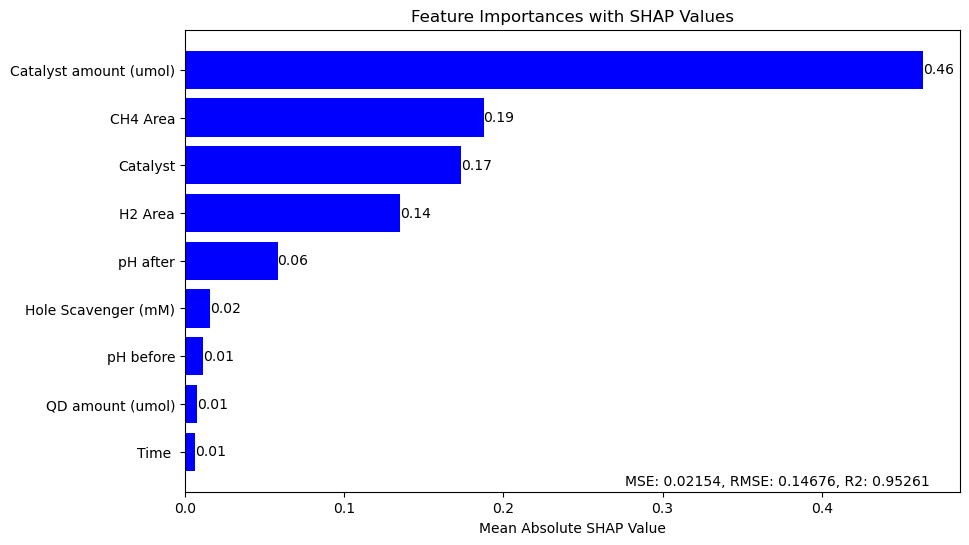

In [45]:
# Create a SHAP explainer object
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Compute the base value (expected value of the model output)
base_value = explainer.expected_value
plotShap(shap_values)

Best Random State:
Random State    21.000000
MSE              0.021539
RMSE             0.146760
R²               0.952610
Name: 21, dtype: float64


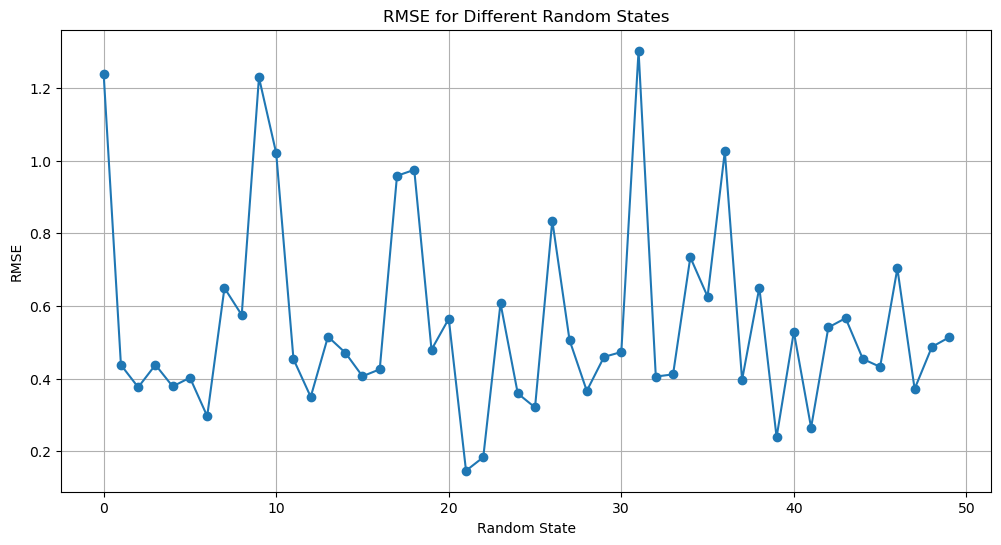

In [46]:
# Try different random states and record performance
results = []
for random_state in range(50):  # Try 50 different random states
    mse, rmse, r2 = evaluate_random_state_xgb(random_state)
    results.append((random_state, mse, rmse, r2))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Random State', 'MSE', 'RMSE', 'R²'])

# Find the best random state based on RMSE
best_random_state = results_df.loc[results_df['RMSE'].idxmin()]

print("Best Random State:")
print(best_random_state)

# Optionally, plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(results_df['Random State'], results_df['RMSE'], marker='o')
plt.title('RMSE for Different Random States')
plt.xlabel('Random State')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


# Bagging Regressor 

/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:509: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


RMSE:  0.28017786375719755
Mean Absolute Error of the model is:  0.17051905954222746
Аccuracy : -0.8958942303548676
Scores: [0.61633295 0.11419091 0.7774724  0.71216812 0.36030444 0.33212818
 0.4672287  1.43523379 0.63155001 0.55543249]
Mean: 0.6002041994381018
Standard deviation: 0.3358257897049371


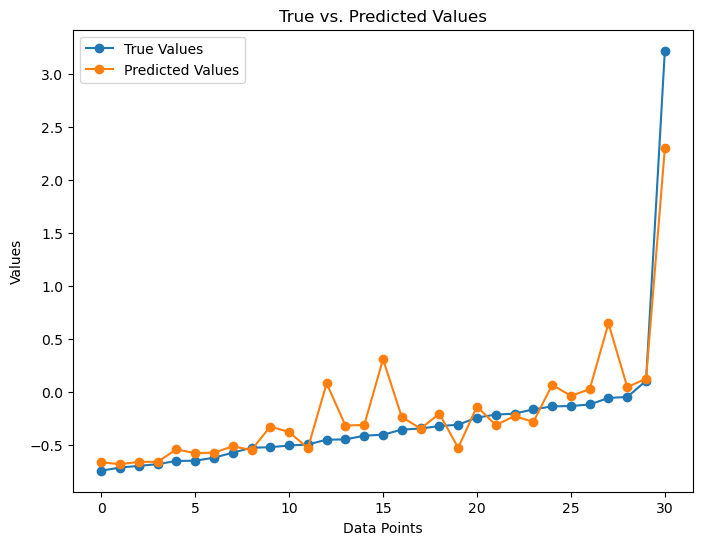

In [48]:
bag = BaggingRegressor(
    VotingRegressor(estimators=[('dtr', dtr), ('rfr', rfr)]), n_estimators=500,
    max_samples=70, bootstrap=True, n_jobs=-1, random_state=42)
bag.fit(x_train, y_train)
pred = bag.predict(X_test)

#Sorting
dictionary = {index: prediction for index, prediction in zip(index_before, pred)}
pred = np.array([dictionary[idx] for idx in sorted_indices])

print('RMSE: ', mean_squared_error(Y_test, pred)**0.5)
#Calculation of Mean Absolute Error
mae = mean_absolute_error(Y_test, pred)
print('Mean Absolute Error of the model is: ', mae)
accuracy = model.score(X_test, Y_test)
print("Аccuracy", ":", accuracy)

scores = cross_val_score(model, x_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)
plt.figure(figsize=(8, 6))

# Plot true values
plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# Plot predicted values
plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')


# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs. Predicted Values')
plt.legend()

plt.show()

# # Calculate differences
# difference = [p - t for p, t in zip(pred, Y_test)]

# # Create DataFrame
# dt = {'True Values': Y_test,
#         'Predicted Values': pred,
#         'Difference': difference}

# df = pd.DataFrame(dt)
# df

# Perceptron (ANN)

In [50]:
#per = Perceptron(max_iter=100, random_state=42)
#per.fit(x_train, y_train)

# DNN

Epoch 1/500


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.6062 - val_loss: 0.7053
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3638 - val_loss: 0.6354
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2949 - val_loss: 0.5909
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1667 - val_loss: 0.5632
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9200 - val_loss: 0.5414
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8556 - val_loss: 0.5323
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0143 - val_loss: 0.5326
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8715 - val_loss: 0.5436
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8819 - val_loss: 0.5533
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7132 - val_loss: 0.5512
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7852 - val_loss: 0.5292
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8080 - val_loss: 0.4972
E

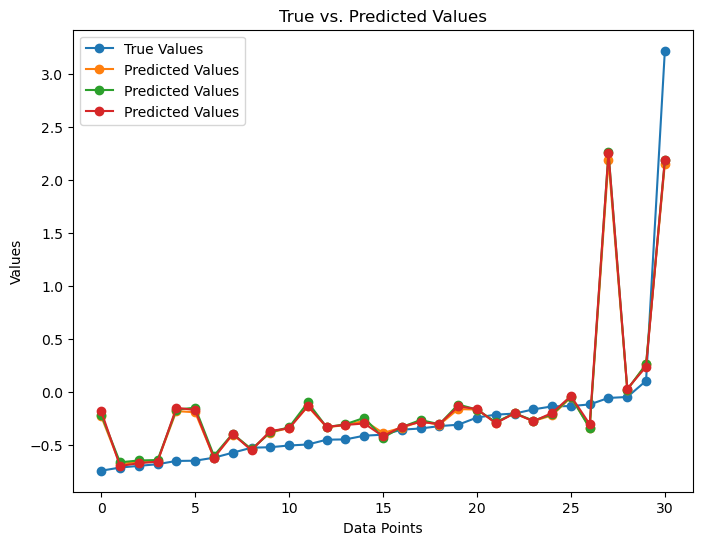

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout

model = Sequential([
    Dense(100,input_shape=(9,)),
    LeakyReLU(alpha=0.1), 
    Dropout(0.1),  
    Dense(100),  
    LeakyReLU(alpha=0.1), 
    Dropout(0.1),  
    Dense(100), 
    LeakyReLU(alpha=0.1), 
    Dropout(0.1),  
    Dense(3)  
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=500, batch_size=32, validation_split=0.2)

loss = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)

pred = model.predict(X_test)

#Sorting
dictionary = {index: prediction for index, prediction in zip(index_before, pred)}
pred = np.array([dictionary[idx] for idx in sorted_indices])

rmse_scores = np.sqrt(-scores)

display_scores(rmse_scores)
plt.figure(figsize=(8, 6))

# Plot true values
plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# Plot predicted values
plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')


# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('True vs. Predicted Values')
plt.legend()

plt.show()



# RNN (Recurrent Neural Network)

In [54]:
# from tensorflow.keras.layers import SimpleRNN
# model = Sequential([
#     SimpleRNN(64, input_shape=(10,1)),  # RNN layer with 64 neurons
#     Dropout(0.2),  # Dropout layer to prevent overfitting
#     SimpleRNN(64),  # RNN layer with 64 neurons
#     Dropout(0.2),  # Dropout layer to prevent overfitting
#     SimpleRNN(32),  # RNN layer with 32 neurons
#     Dropout(0.2),  # Dropout layer to prevent overfitting
#     Dense(3)  # Output layer with no activation function for regression
# ])

# model.compile(optimizer='adam', loss='mean_squared_error')

# X_train_RNN = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# X_test_RNN = x_test.reshape((X_test.shape[0], X_test.shape[1], 1))
# Y_train_RNN = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
# Y_test_RNN = y_test.reshape((Y_test.shape[0], Y_test.shape[1], 1))

# model.fit(X_train_RNN, Y_train_RNN, epochs=50, batch_size=32, validation_split=0.2)

# loss = model.evaluate(X_test_RNN, Y_test_RNN)
# print("Test Loss:", loss)

# pred = model.predict(X_test_RNN)

# rmse_scores = np.sqrt(-scores)
# display_scores(rmse_scores)
# plt.figure(figsize=(8, 6))

# # Plot true values
# plt.plot(range(len(Y_test)), Y_test, label='True Values', marker='o')

# # Plot predicted values
# plt.plot(range(len(pred)), pred, label='Predicted Values', marker='o')


# # Add labels and legend
# plt.xlabel('Data Points')
# plt.ylabel('Values')
# plt.title('True vs. Predicted Values')
# plt.legend()

# plt.show()



# Prediction 

In [56]:
print(columns_f)
print(label_mapping)
pred = voter.predict([[6,100,1000,100,4000,1000,6,4,20]])
print(pred) # 24 hours
pred = pred.reshape(1,-1)
#data_pipeline.inverse_transform(pred)


Index(['Catalyst', 'Hole Scavenger (mM)', 'Catalyst amount (umol)',
       'QD amount (umol)', 'H2 Area', 'CH4 Area', 'pH before', 'pH after',
       'Time '],
      dtype='object')
{'Co-TPP-COOH4': 0, 'CoCl2': 1, 'FeCl2': 2, 'FeCl3': 3, 'MnCl2': 4, 'ZnAc2': 5, 'ZnCl2': 6, nan: 7}
[0.54986381]


/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/yuriisulima/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


# RL Model 